# Predict Home Value using IBM Watson Machine Learning and Db2 on Cloud

In this notebook, we will be showing you how to create a machine learning model to predict home sales. At the same time, we will be use IBM's Db2 on Cloud database to store and recieve data for this exercise. In this notebook, we will be going through the entire data science process of creating a model which includes: Importing Data, Preprocessing Data, Data Exploration, Data Visualization and Data Modeling. We will try to fitting our data with differeent models and see which one gives us the best resuts. At the end of this notebook, we will be deploying our model using Watson Machine Learning so it can used in an application to predict new home sales price. Hope you guys have fun!

### Learning Goals

The learning goals of this notebook are:

    1. Load data and create dataframe by connecting to IBM Db2 on cloud
    2. Explore and Visualize Data
    2. Create a Sklearn models and determine which is the best model to use 
    3. Train different models and evaluate which is the best model to use 
    4. Persist a model in a Watson Machine Learning repository
    5. Predict home value using the model


In [19]:
!pip install --upgrade ibmos2spark
!pip install --upgrade watson-machine-learning-client

import numpy as np
import pandas as pd

Requirement already up-to-date: ibmos2spark in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.0.1)
Requirement already up-to-date: watson-machine-learning-client in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.0.371)


# 1. IMPORTING DATA

The first step as data scienctist is to import our data from our data source. In real a world application, your data is going to be too big to be stored locally on your computer. Due to that, your data will most likely be stored on the cloud or in some other method. For the purposes of this notebook, our data is store on IBM Db2 on Cloud. In order to retrieve data from there, we are going to import IBM's python model `ibmdbpy` that allows Python users to import data from IBM's databases. Our data is stored in schema `SKP44849` and the table name is `HOME_SALES`.

In [20]:

from ibmdbpy import IdaDataBase, IdaDataFrame

# @hidden_cell
# This connection object is used to access your data and contains your credentials.
# You might want to remove those credentials before you share your notebook.
idadb_2cffb71b4b2348ab8a466c773c64691a = IdaDataBase(dsn='DASHDB;Database=BLUDB;Hostname=dashdb-txn-sbox-yp-dal09-04.services.dal.bluemix.net;Port=50000;PROTOCOL=TCPIP;UID=skp44849;PWD=19btf^dph1ng0cnb')

pd_df = IdaDataFrame(idadb_2cffb71b4b2348ab8a466c773c64691a, 'SKP44849.HOME_SALES').as_dataframe()
pd_df.head()

# You can close the database connection with the following code. Please keep the comment line with the @hidden_cell tag,
# because the close function displays parts of the credentials.
# @hidden_cell
# idadb_2cffb71b4b2348ab8a466c773c64691a.close()
# To learn more about the ibmdby package, please read the documentation: http://pythonhosted.org/ibmdbpy/


,ID,LOTAREA,BLDGTYPE,HOUSESTYLE,OVERALLCOND,YEARBUILT,ROOFSTYLE,EXTERCOND,FOUNDATION,BSMTCOND,...,GARAGETYPE,GARAGEFINISH,GARAGECARS,GARAGECOND,POOLAREA,POOLQC,FENCE,MOSOLD,YRSOLD,SALEPRICE
0,1,8450,1Fam,2Story,5,2003,Gable,TA,PConc,TA,...,Attchd,RFn,2,TA,0,NA,NA,2,2008,208500
1,2,9600,1Fam,1Story,8,1976,Gable,TA,CBlock,TA,...,Attchd,RFn,2,TA,0,NA,NA,5,2007,181500
2,3,11250,1Fam,2Story,5,2001,Gable,TA,PConc,TA,...,Attchd,RFn,2,TA,0,NA,NA,9,2008,223500
3,4,9550,1Fam,2Story,5,1915,Gable,TA,BrkTil,Gd,...,Detchd,Unf,3,TA,0,NA,NA,2,2006,140000
4,5,14260,1Fam,2Story,5,2000,Gable,TA,PConc,TA,...,Attchd,RFn,3,TA,0,NA,NA,12,2008,250000


By the end of this step, we should have your data imported from your data source and store in memory, so we can use it to create our model. In the next step, we are going to clean our data and make it ready for exploration and modeling.

# 2. Data Exploration

In this step, we are going to try and explore our data inorder to gain insight. We hope to be able to make some assumptions of our data before we start modeling.

In [21]:
pd_df.describe()

,ID,LOTAREA,OVERALLCOND,YEARBUILT,FULLBATH,HALFBATH,BEDROOMABVGR,KITCHENABVGR,TOTRMSABVGRD,FIREPLACES,GARAGECARS,POOLAREA,MOSOLD,YRSOLD,SALEPRICE
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,10516.828082,5.575342,1971.267808,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1.767123,2.758904,6.321918,2007.815753,180921.195890
std,421.610009,9981.264932,1.112799,30.202904,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,0.747315,40.177307,2.703626,1.328095,79442.502883
min,1.000000,1300.000000,1.000000,1872.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,7553.500000,5.000000,1954.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,9478.500000,5.000000,1973.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,11601.500000,6.000000,2000.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,215245.000000,9.000000,2010.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,4.000000,738.000000,12.000000,2010.000000,755000.000000


 The count, mean, min and max rows are self-explanatory. The std shows the standard deviation, and the 25%, 50% and 75% rows show the corresponding percentiles.

In [22]:
# Minimum price of the data
minimum_price = np.amin(pd_df['SALEPRICE'])

# Maximum price of the data
maximum_price = np.amax(pd_df['SALEPRICE'])

# Mean price of the data
mean_price = np.mean(pd_df['SALEPRICE'])

# Median price of the data
median_price = np.median(pd_df['SALEPRICE'])

# Standard deviation of prices of the data
std_price = np.std(pd_df['SALEPRICE'])

# Show the calculated statistics
print("Statistics for housing dataset:\n")
print("Minimum price: ${}".format(minimum_price)) 
print("Maximum price: ${}".format(maximum_price))
print("Mean price: ${}".format(mean_price))
print("Median price ${}".format(median_price))
print("Standard deviation of prices: ${}".format(std_price))

Statistics for housing dataset:

Minimum price: $34900
Maximum price: $755000
Mean price: $180921.19589041095
Median price $163000.0
Standard deviation of prices: $79415.29188606751


# 3. Data Visualization

As a data scientist it is important to make assumptions and hypothesiize about our data as we continue to explore our data. Some assumptions that we can make about the data are: 

1. Homes with more rooms will naturally worth more. Usually homes with more rooms are bigger and can fit more people, so it is reasonable that they cost more money.
2. Homes that have recently been built will cost more. Since they are newer and probably have a better design compared to older houses. 
3. Having a garage will also increase the price of the house and will increase more as the number of cars the garage can hold increases. 
4. House Style is usually a personal opinion for the buyer, so it shouldn't have that much impact on the cost of the home sale.

These are just a few of the assumptions we can make so far from our data. As we move into the visualizing our data, we hope to see patterns that are hard to notice just by looking at the numbers. 

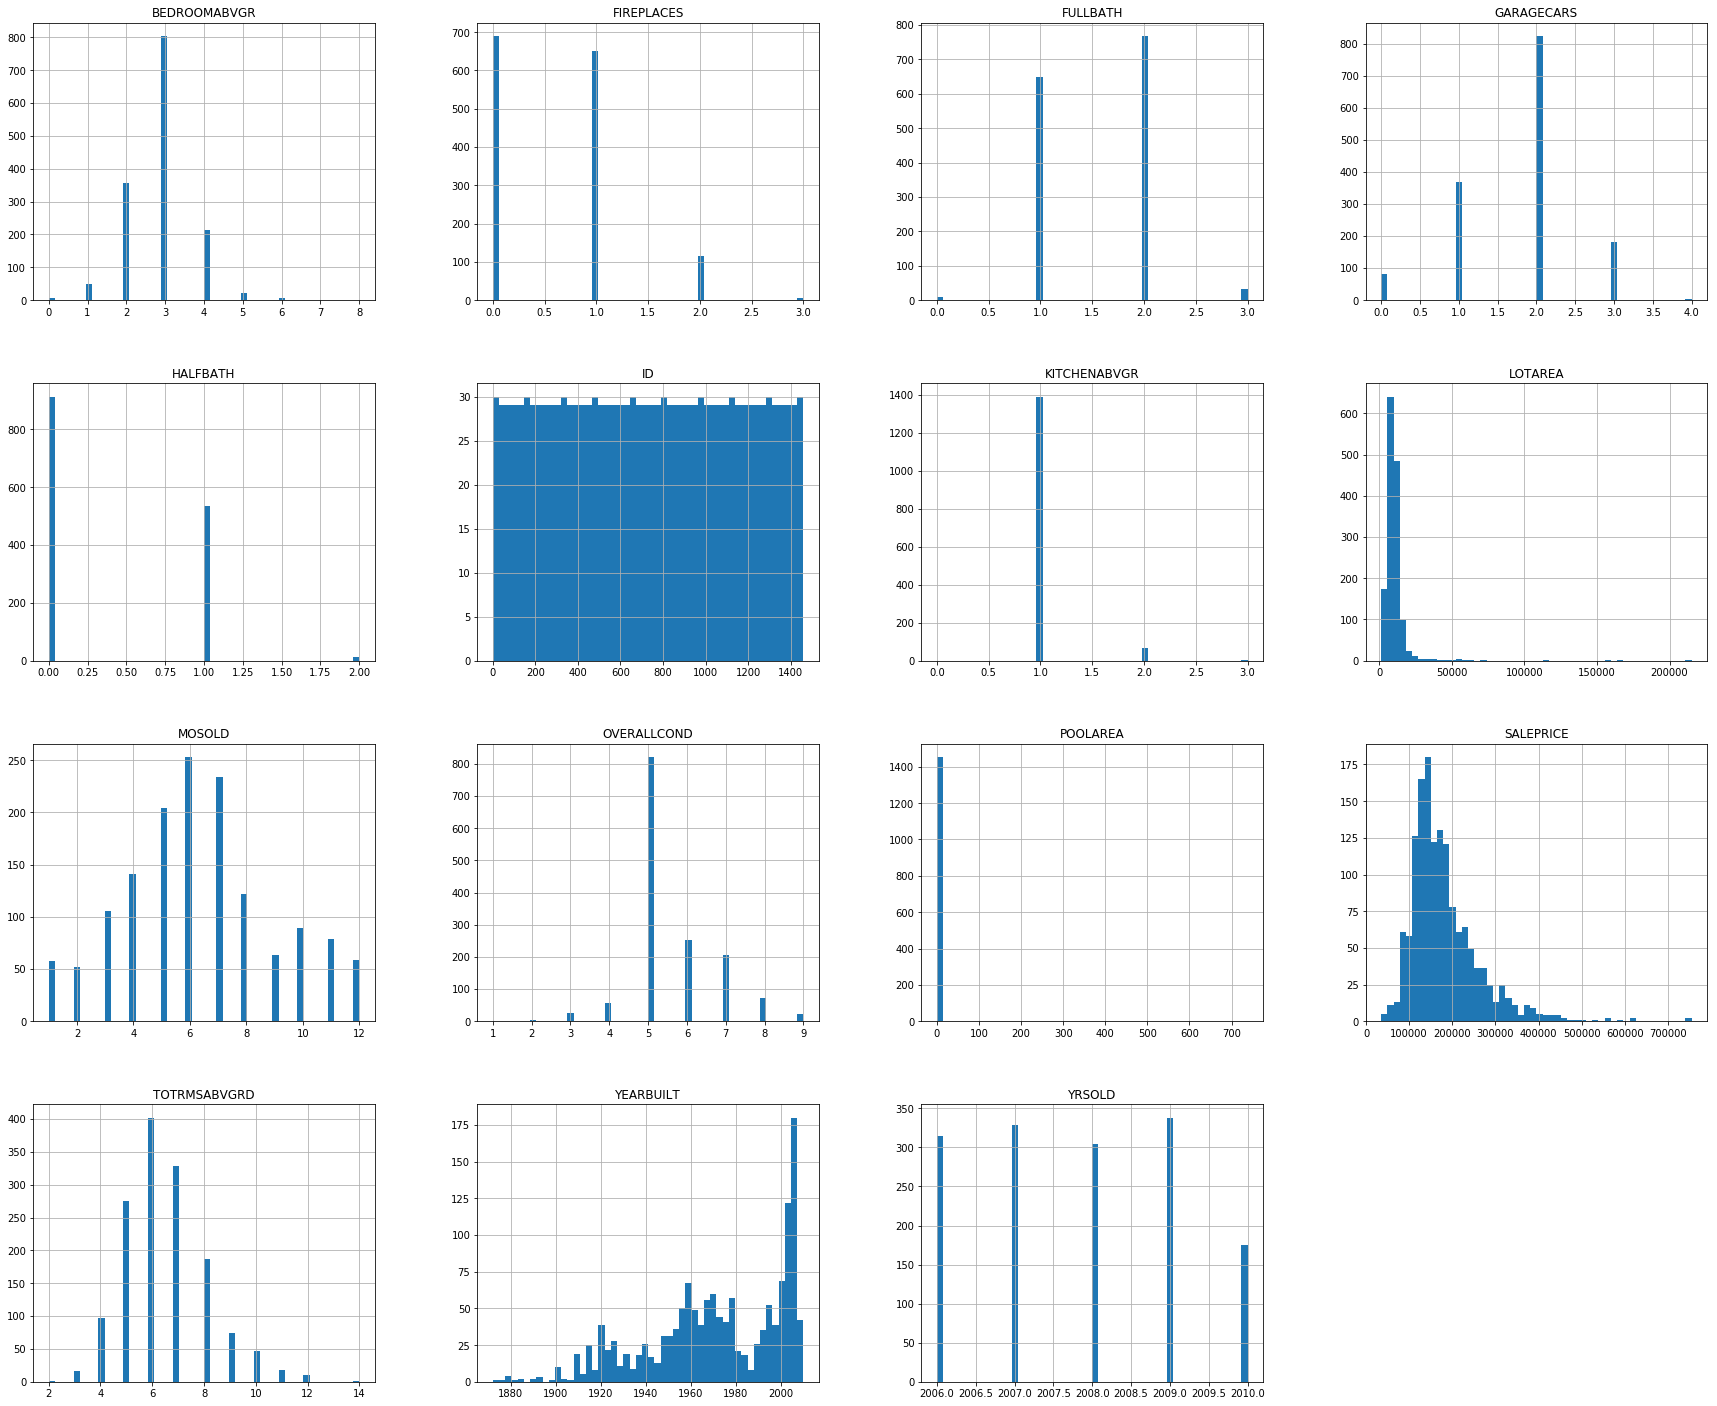

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

pd_df.hist(bins=50, figsize=(30,25))
plt.show()

Some of the figures are skewed a little, but most of them have a normal distribution. This is normal to have.

The variable we are going to predict is the SALEPRICE. Let’s look at how much each independent variable correlates with this dependent variable.

In [24]:
corr_matrix = pd_df.corr()
corr_matrix["SALEPRICE"].sort_values(ascending=False)

SALEPRICE       1.000000
GARAGECARS      0.640409
FULLBATH        0.560664
TOTRMSABVGRD    0.533723
YEARBUILT       0.522897
FIREPLACES      0.466929
HALFBATH        0.284108
LOTAREA         0.263843
BEDROOMABVGR    0.168213
POOLAREA        0.092404
MOSOLD          0.046432
ID             -0.021917
YRSOLD         -0.028923
OVERALLCOND    -0.077856
KITCHENABVGR   -0.135907
Name: SALEPRICE, dtype: float64

The SALEPRICE seems to be increasing when the GARAGECARS and the FULLBATH increase. We can also see a negative correlation between SALEPRICE and FOUNDATION and a couple others. And finally, coefficients close to zero indicate that there is no linear correlation. However, we barely see any cofficients close to zeros, this tells us that all the attributes are important to SALEPRICE, which is the attribute we are predicting.

# 4. Modeling

Now that we have cleaned and explored our data. We are ready to build our model that will predict the attribute `SALEPRICE`. One of the hardest part in the process is determining which model to use for a particular problem. However, since we are using Python's machine learning library [scikit-learn](https://scikit-learn.org/stable/), we will be able to build and test different models quickly and determine which one is the best to use. We will be building three models:


1. [Linear Regression Model](https://towardsdatascience.com/linear-regression-using-python-b136c91bf0a2)
2. [Random Forest Model](https://www.distilnetworks.com/glossary/term/random-forest-model/)
3. [Gradient Boosting](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)

IMPORT NOTE: THE METRIC RESULTS MAY BE A LITTLE DIFFERENT SINCE WE ARE SHUFFLING THE DATA WHEN WE CALL train_test_split()

## 4a. Splitting Our Data 
Before we can build our model, we need to split our data into test and train data. We will also be shuffling our data to make sure there isn't any bias when creating the model. Since having any bias in our model will lower the accuracy of our model. 

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import numpy as np

# train, test = train_test_split(pd_df, test_size=0.2)
# print("Number of training records: " + str(train.count()))
# print("Number of testing records : " + str(test.count()))


y = pd_df['SALEPRICE']

pd_df = pd_df.drop(['SALEPRICE','ID'],  axis=1)


le = LabelEncoder()
X_2 = pd_df.apply(le.fit_transform)

enc = OneHotEncoder(handle_unknown='ignore')
ft = enc.fit(X_2)

onehotlabels = enc.transform(X_2).toarray()
onehotlabels.shape

#print(onehotlabels[:,len(onehotlabels)-1])

# print(onehotlabels)

x = X_2

#x = np.delete(onehotlabels, -1, axis=1)

#y = onehotlabels[:,len(onehotlabels)-1]


x_train, x_test, y_train, y_test = train_test_split( x,y)


## 4b. Developing The Model with Linear Regression 

Our first model that we are going to build is a linear regression model. This is one of the simplest models to implement and also has a high accuracy as well. We will be importing the `LinearRegression` module from the `sklearn` library.

In [26]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression(fit_intercept=False)
linear_regression_model = regressor.fit(x_train, y_train)

Now that we have built our model, let's use the model to predict the home sales value.

In [27]:
y_pred = regressor.predict(x_test)

Let's take a look at the predictions our model gave us

In [28]:
print('Predictions: \n', y_pred)

Predictions: 
 [213759.36681944  78132.47775109 221326.94434864 103441.92276772
 249603.60774791 102804.3916947  219249.44790518  94345.51829835
  90174.26372378 123240.08228761  76844.01293337 242759.95115562
 301387.04130638 126942.99883553 295002.83558339 259223.16463846
 258571.7328816   50509.37925198 194024.32422114 283880.06902659
 168276.76597101 189835.25457716 354597.25951079 224108.51965976
 193642.38882898 177835.11035938 196629.47810457 238145.77475087
 341014.89592238  76416.6956219  188751.32493678 107621.15280892
 318668.38577231 212200.73840781 368704.34863174 243151.70234887
 283861.3557868  208767.52492192 165961.21203011 159346.61998329
 203958.99145321 178070.93402262 262378.04387886 140276.03818193
 203359.15248067 181862.65689416 215196.70194599 236636.78733525
 210513.95628063 190481.64100605 109655.39932592 316018.15833737
 190559.53181926 251741.1512482  161651.05112335 135917.98533225
 138318.10495595 299022.15238195 162972.32093226 225444.05375345
 180862.21

Let's also take a look at the coefficients for this model

In [29]:
y_pred = regressor.predict(x_test)
# The coefficients
print('Coefficients: \n', regressor.coef_)
# print('Linear Regression R squared": %.4f' % regressor.score(x_test, y_test))

Coefficients: 
 [    38.15195493   -776.93186161  -1809.30158242   6898.50370258
    515.53358687   7890.6695748     806.73004007   1673.37683299
   2744.50706558   -173.91071684  -1087.21395035   8593.69426144
   -600.72344923  17833.57299137   6828.99385051  -9302.49337768
 -31325.62720823 -19149.12525811  13835.56719958  15051.34011682
  -2858.49271012    980.70070629  -4265.6948765   22492.85207803
   -560.09268469  23756.19652891  13674.66547241   1200.35087185
    622.2536102    -106.97688462]




Let's calculate root-mean-square error (RMSE) and see if we can gain more information about our model.

In [30]:
import numpy as np
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)

Linear Regression RMSE: 39826.1481


Our model was able to predict the value of every house in the test set within $43101.9709 of the real price. 





In [31]:
from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(y_pred, y_test)
print('Linear Regression MAE: %.4f' % lin_mae)

Linear Regression MAE: 25899.4523


## 4c. Devloping The Model with Random Forest

Now that we tried to fit our dataset to a linear regression model. Let's try a more complex model and see if our accuracy can improve. We will fit our model to the Random Forest Model in this section. We will be importing the `RandomForestRegressor` module from the `sklearn` library.

In [32]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(x_train, y_train)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [33]:
print('Random Forest R squared": %.4f' % forest_reg.score(x_test, y_test))

Random Forest R squared": 0.7272


In [34]:
y_pred = forest_reg.predict(x_test)
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest RMSE: 41742.4499


As you can see from the metrics performed, we are getting much better results compared to the Linear Regression model. In our Linear Regression model, the R2 was around 70%, however now it has increase to 82%! This means that the Random Forest model is fitting our data much better compared to the Linear Regression Model. When comparing our RMSE, it has also decreased significantly alluding that there is less variabliity in our model now. 

Let's try to fit our dataset to one more model and see if we can improve our metrics.

## 4d. Devloping The Model with Gradient Boosting

Our last model we are going to fit our data to is Gradient Boosting. We will be importing the `GradientBoostingRegressor` module from the `sklearn` library.

In [35]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
model = ensemble.GradientBoostingRegressor()
model.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [36]:
print('Gradient Boosting R squared": %.4f' % model.score(x_test, y_test))

Gradient Boosting R squared": 0.7539


In [37]:
y_pred = model.predict(x_test)
model_mse = mean_squared_error(y_pred, y_test)
model_rmse = np.sqrt(model_mse)
print('Gradient Boosting RMSE: %.4f' % model_rmse)

Gradient Boosting RMSE: 39648.7992


We notice that the metrics are significantly better than the Linear Regression model, however not as good as the Random Forest model.

# 5. Deploying Model

From our evalution, we can see that our Random Forest Model performed best out of the models we trained. For this reason we are going to use the that model for deploy. Below are the instructions to deploy our model.

In [38]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
wml_credentials = {
    "apikey": "lTTmIn-wYlhjFNADvEZnTMkNxZk2X9gRbUWruUHure8E",
    "username": "298f9780-c3a0-4bee-a884-44fa9f43fd8d",
    "password": "3f4909b0-f69e-4b2e-9ed1-7b6a864fedad",
    "instance_id": "1f171325-6a6f-4e5b-978c-0954f87d2188",
    "url": "https://us-south.ml.cloud.ibm.com"
}
client = WatsonMachineLearningAPIClient(wml_credentials)

In [39]:
runtimes_meta = {
    client.runtimes.ConfigurationMetaNames.NAME: "Home_Sale_Model", 
    client.runtimes.ConfigurationMetaNames.DESCRIPTION: "Home Sale Model hype", 
    client.runtimes.ConfigurationMetaNames.PLATFORM: { "name": "python", "version": "3.6" }, 
}
runtime_details = client.runtimes.store(runtimes_meta)
runtime_details
runtime_url = client.runtimes.get_url(runtime_details)
runtime_uid = client.runtimes.get_uid(runtime_details)
print("Runtimes URL: " + runtime_url)
print("Runtimes UID: " + runtime_uid)

Runtimes URL: https://us-south.ml.cloud.ibm.com/v4/runtimes/96084e00-42e5-49c3-8fc2-f378171f8016
Runtimes UID: 96084e00-42e5-49c3-8fc2-f378171f8016


In [40]:
model_props = {client.repository.ModelMetaNames.NAME: "Home Sale Model hype",
               client.repository.ModelMetaNames.RUNTIME_UID: runtime_uid
              }
published_model = client.repository.store_model(model=forest_reg, meta_props=model_props)
import json
published_model_uid = client.repository.get_model_uid(published_model)
model_details = client.repository.get_details(published_model_uid)
print(json.dumps(model_details, indent=2))


{
  "metadata": {
    "guid": "f5052e1f-32ca-4f56-9e71-09f2fb1047f6",
    "url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/1f171325-6a6f-4e5b-978c-0954f87d2188/published_models/f5052e1f-32ca-4f56-9e71-09f2fb1047f6",
    "created_at": "2019-07-29T18:36:55.269Z",
    "modified_at": "2019-07-29T18:36:55.331Z"
  },
  "entity": {
    "runtime_environment": "python-3.6",
    "learning_configuration_url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/1f171325-6a6f-4e5b-978c-0954f87d2188/published_models/f5052e1f-32ca-4f56-9e71-09f2fb1047f6/learning_configuration",
    "name": "Home Sale Model hype",
    "learning_iterations_url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/1f171325-6a6f-4e5b-978c-0954f87d2188/published_models/f5052e1f-32ca-4f56-9e71-09f2fb1047f6/learning_iterations",
    "feedback_url": "https://us-south.ml.cloud.ibm.com/v3/wml_instances/1f171325-6a6f-4e5b-978c-0954f87d2188/published_models/f5052e1f-32ca-4f56-9e71-09f2fb1047f6/feedback",
    "latest_ve

In [41]:
created_deployment = client.deployments.create(published_model_uid, name="Home_Sale_Model")



#######################################################################################

Synchronous deployment creation for uid: 'f5052e1f-32ca-4f56-9e71-09f2fb1047f6' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='be461422-0e0a-4013-bf54-fc63e7b027f3'
------------------------------------------------------------------------------------------------




# 6.  Predict using the deployed mode

Get the URL that is to be used for prediction. The prediction URL is obtained from the deployment details of the deployment created above.

In [42]:
scoring_endpoint = client.deployments.get_scoring_url(created_deployment)
print(scoring_endpoint)

https://us-south.ml.cloud.ibm.com/v3/wml_instances/1f171325-6a6f-4e5b-978c-0954f87d2188/deployments/be461422-0e0a-4013-bf54-fc63e7b027f3/online


Prepare the payload for prediction. The payload contains the input records for which predictions has to be performed.

In [43]:
scoring_payload = {'fields': ['LOTAREA', 'BLDGTYPE', 'HOUSESTYLE', 'OVERALLCOND', 'YEARBUILT',
       'ROOFSTYLE', 'EXTERCOND', 'FOUNDATION', 'BSMTCOND', 'HEATING',
       'HEATINGQC', 'CENTRALAIR', 'ELECTRICAL', 'FULLBATH', 'HALFBATH',
       'BEDROOMABVGR', 'KITCHENABVGR', 'KITCHENQUAL', 'TOTRMSABVGRD',
       'FIREPLACES', 'FIREPLACEQU', 'GARAGETYPE', 'GARAGEFINISH', 'GARAGECARS',
       'GARAGECOND', 'POOLAREA', 'POOLQC', 'FENCE', 'MOSOLD', 'YRSOLD' ], 
                   'values': [[598,0,2,7,0,1,4,1,4,1, 0,1,5,2,0,3,1,3,4,1,5,1,2,2,5,0,3,4,4,1]]}

Execute the method to perform online predictions and display the prediction results.

In [44]:
predictions = client.deployments.score(scoring_endpoint, scoring_payload)

In [45]:
print(json.dumps(predictions, indent=2))

{
  "fields": [
    "prediction"
  ],
  "values": [
    [
      175400.0
    ]
  ]
}


# 7. Conclusion

At the end of our modeling step, we built three models: `Linear Regression`, `Random Forest` and `Gradient Boosting`. We noticed that the `Random Forest` model gave us the best results compared to the other two. We could also say that our `Random Forest` model did the best job in describing our dataset compared to the other models.

Hopefully you were able to experience the Data Science process through these steps. As well as learn how to use IBM's Db2 on Cloud database as a data source for future machine learning projects and IBM's Watson Studio as a platform to build models. See you guys next time!